# Twitter sentiment analysis

Pau Roger Puig-Sureda,  28/03/2018

## Goal

Using **R**, predict if tweets have a negative, neutral or positive sentiment towards several airlines.

In [1]:
# If needed, uncomment the following to install all required packages:
# install.packages(
#  c("caret", "data.table", "e1071", "ggplot2", "kernlab", "magrittr", 
#    "naivebayes", "plyr", "randomForest" ,"SnowballC", "tm", "xgboost")
# )

In [29]:
# Libraries in alphabetical order.
library(caret)
library(data.table)
library(e1071)
library(ggplot2)
library(kernlab)
library(magrittr)
library(naivebayes)
library(plyr)
library(randomForest)
library(SnowballC)
library(tm)
library(xgboost)

# Configs.
# Supress warnings
options(warn=-1)

In [3]:
# Import data.
train <- read.csv(
    file = file.path("./data/training.csv"), stringsAsFactors = TRUE
    )
test <- read.csv(file = file.path("./data/test.csv"), stringsAsFactors = TRUE)

cat("Shape of the train dataset:", dim(train))
cat("\nShape of the test dataset:", dim(test), "\n\n")

print("As we can see, variable 'X.5' from the train dataset does not appear \
    in the test one plus it does not add any value:")
print(count(train$X.5))

Shape of the train dataset: 7000 16
Shape of the test dataset: 7640 14 

[1] "As we can see, variable 'X.5' from the train dataset does not appear \n    in the test one plus it does not add any value:"
          x freq
1           6999
2 New Delhi    1


In [4]:
# I will delete said feature.
train$X.5 <- NULL

# I will now add the target column 'airline_sentiment' into the test 
# dataset. So that i can merge both dataframes. This way analysis and 
# transformations are done only once, I will split them again before 
# modeling.
test$airline_sentiment <- as.factor(NA)

# Now that we have the same number of columns in both datasets:
joined <- rbind(train, test)

head(joined)

tweet_id,airline_sentiment,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,X,X.1,X.2,X.3,X.4
<dbl>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
5.677744e+17,negative,United,kristofurmac,0,@united no they were to busy taking to each other and I needed to get to an audition.,,2015-02-17 11:55:49 -0800,LA,,,,,,
5.680326e+17,neutral,US Airways,MiddleSeatView,0,"@USAirways if there are empty first class seats on my flight at check in, why wouldn't I be automatically upgraded?",,2015-02-18 05:01:30 -0800,"Washington, D.C.",Atlantic Time (Canada),,,,,
5.684454e+17,positive,Southwest,Omnicom,0,@SouthwestAir @FortuneMagazine Congrats!,,2015-02-19 08:22:02 -0800,Worldwide,Atlantic Time (Canada),,,,,
5.699783e+17,neutral,American,DigitalEdMom,0,@AmericanAir 3127. Just landed in LIT.,,2015-02-23 13:53:14 -0800,Wisconsin,Central Time (US & Canada),,,,,
5.697210e+17,negative,American,OnePoundOne,0,@AmericanAir @ArminRosen @ggreenwald Tell that piece of shit to get fucked... I'll fly exclusively with you for life...,,2015-02-22 20:50:38 -0800,Chicago,,,,,,
5.702113e+17,neutral,United,BouleChitte,0,@united how about 3659 YUL-ORD?,,2015-02-24 05:19:05 -0800,,,,,,,


In [5]:
# Change factors to numbers of the target variable.
joined$airline_sentiment <- as.factor(
    unclass(joined$airline_sentiment) %>% as.numeric
    )

# Check for NA's
na.cols <- which(colSums(is.na(joined)) > 0)
sort(colSums(sapply(joined[na.cols], is.na)), decreasing = TRUE)

airline_sentiment 
             7640

The only null values that we have in the dataset are the ones we need to predict.

In [6]:
# Feature analysis
summary(joined)

    tweet_id         airline_sentiment           airline    
 Min.   :5.676e+17   1   :4373         American      :2759  
 1st Qu.:5.686e+17   2   :1498         Delta         :2222  
 Median :5.695e+17   3   :1129         Southwest     :2420  
 Mean   :5.692e+17   NA's:7640         United        :3822  
 3rd Qu.:5.699e+17                     US Airways    :2913  
 Max.   :5.703e+17                     Virgin America: 504  
                                                            
          name       retweet_count                           text      
 JetBlueNews:   63   Min.   : 0.00000   @united thanks         :    6  
 kbosspotter:   32   1st Qu.: 0.00000   @AmericanAir thanks    :    5  
 _mhertz    :   29   Median : 0.00000   @JetBlue thanks!       :    5  
 otisday    :   28   Mean   : 0.08265   @SouthwestAir sent     :    5  
 throthra   :   27   3rd Qu.: 0.00000   @AmericanAir thank you!:    4  
 rossj987   :   23   Max.   :44.00000   @united thank you!     :    4  
 (Other)

Few points about the dataset.

* Airlines: American, Delta, Southwest, United, US Airways, and Virgin America.
* Tweet coordinates is quite a mess, it is a mix of text and actual coordinates.
* On the 'location' feature the values are not standardized. I.E. 'New York, NY', 'NYC', 'New York', 'New York City', 'NY'...
* The variable 'X' is a mix of location, date-time, coordinates...
* The 'X.1' and 'X.4' columns add very little to no information, since most of its values are empty.

However, I am mostly interested in the natural language processing of the task, which is why I will mostly focus on the tweets alone.

### Visualizations

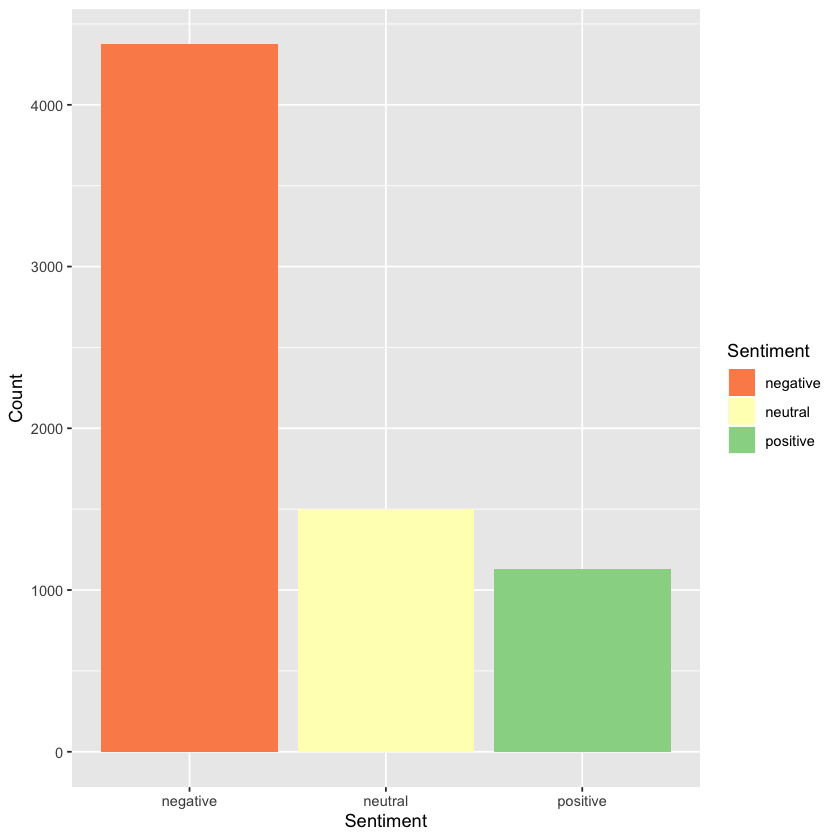

In [7]:
# Count of tweets per sentiment.
sentiment <- as.data.frame(count(train$airline_sentiment))
colnames(sentiment) <- c("Sentiment", "Count")

ggplot(sentiment) + aes(
    x=Sentiment, y=Count, fill=Sentiment
    ) + geom_bar(stat = 'identity') + scale_fill_brewer(palette="Spectral")

We can see that when people tweet about an airline, most of the time is to complain about it. Good service is mainly assumed.

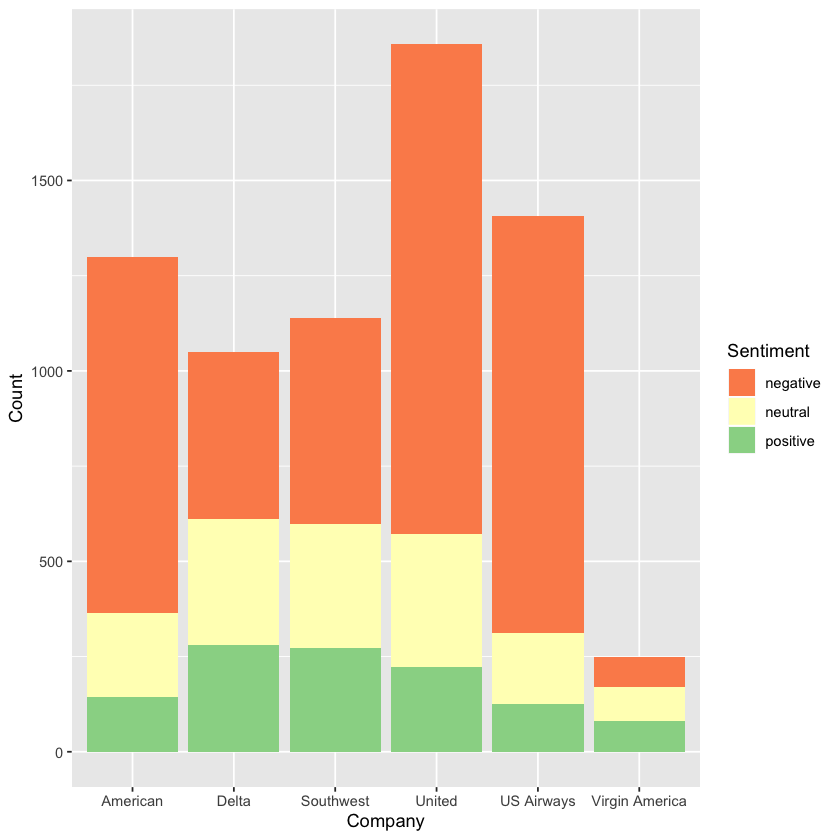

In [8]:
# Count of tweets per sentiment and grouped by airline.
sentiment_bis = as.data.frame(table(train$airline,train$airline_sentiment))
colnames(sentiment_bis) = c("Company", "Sentiment", "Count")

ggplot(sentiment_bis) + aes(x=Company, y=Count, fill=Sentiment) + geom_bar(
    stat = 'identity'
    ) + scale_fill_brewer(palette="Spectral")

'United' is the airline with the most negative tweets, followed by 
'US Airways' and 'American'.

In [9]:
# Tweet content.
# First thing to do is reading the text in the 'tweets'.
corpus <- Corpus(VectorSource(joined$text))

# We can take a look at some examples.
inspect(corpus[1:5])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 5

[1] @united no they were to busy taking to each other and I needed to get to an audition.                                  
[2] @USAirways if there are empty first class seats on my flight at check in, why wouldn't I be automatically upgraded?    
[3] @SouthwestAir @FortuneMagazine Congrats!                                                                               
[4] @AmericanAir 3127. Just landed in LIT.                                                                                 
[5] @AmericanAir @ArminRosen @ggreenwald Tell that piece of shit to get fucked... I'll fly exclusively with you for life...


In [31]:
# Function to apply the following transformations to the corpus: 
# stemming, remove punctuation, strip blanks, remove stopwords and 
# remove links.
cleanCorpus <- function(corpus) {
  corpus <-tm_map(corpus, stemDocument)
  corpus.tmp <- tm_map(corpus, removePunctuation)
  corpus.tmp <- tm_map(corpus.tmp, stripWhitespace)
  corpus.tmp <- tm_map(corpus.tmp, removeWords, stopwords("en"))
  corpus.tmp <- tm_map(corpus, function(x) gsub('http[[:alnum:]]*', '', x))
  return(corpus.tmp)
}

# Clean the 'corpus' variable.
corpus.clean <- cleanCorpus(corpus)

Represent the bag of words tokens with a `document term matrix` (DTM). 
The rows of the DTM will correspond to the documents in the collection, columns to the terms, and its elements are the term frequencies.

In [11]:
dtm <- DocumentTermMatrix(corpus.clean)
print(dtm)

cat("\nShape of the newly created 'bag of words': ", dim(dtm))

<<DocumentTermMatrix (documents: 14640, terms: 23503)>>
Non-/sparse entries: 191830/343892090
Sparsity           : 100%
Maximal term length: 53
Weighting          : term frequency (tf)

Shape of the newly created 'bag of words':  14640 23503

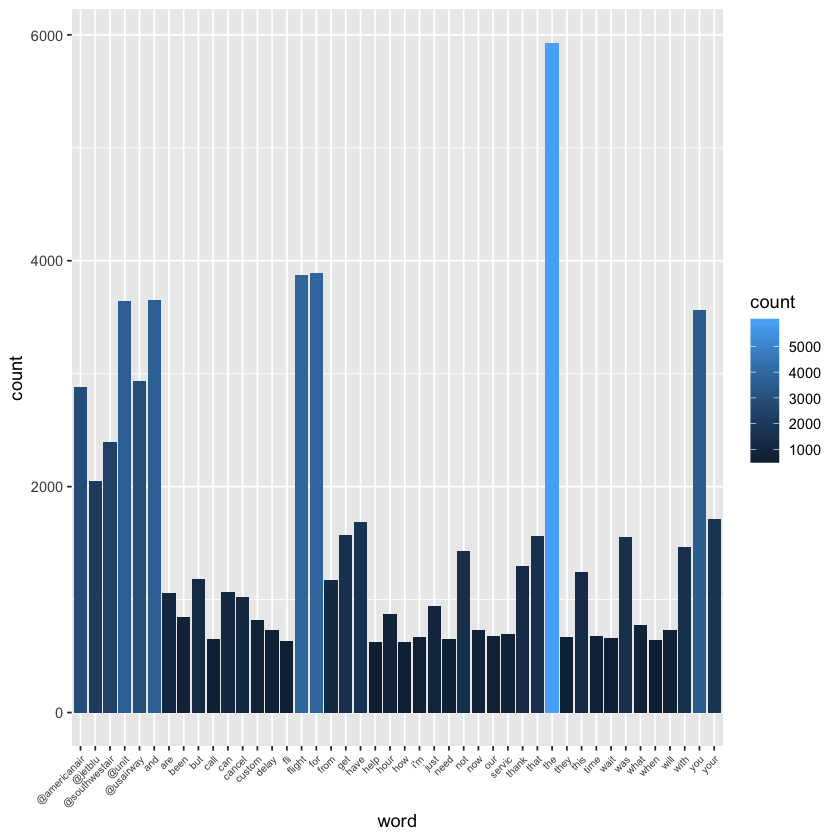

In [12]:
# Countplot of the words that appear more than 600 times (this number is 
# set so that the graph remains readable).
top_words_to_show <- 600
count <- colSums(as.matrix(dtm)) 
word <- order(count)
df = data.frame(word=names(count), count=count)   

ggplot(
    subset(df, count > top_words_to_show), 
    aes(word, count, fill=count)
    ) + geom_bar(
    stat="identity", show.legend=TRUE
) + theme(axis.text.x=element_text(angle=45, hjust=1, size=rel(0.7)))

In [13]:
# Remove the sparse terms in the matrix (i.e., those terms only 
# appearing in a few reviews).
dtm.nb <- removeSparseTerms(dtm, 0.99)

# Converting to a DataFrame.
tweets_df <- as.data.frame(as.matrix(dtm.nb))
colnames(tweets_df) <- make.names(colnames(tweets_df))
tweets_df$airline_sentiment <- joined$airline_sentiment

# Print shape of the bag of words dataframe.
dim(tweets_df)

[1] 14640   204

In [14]:
# As we saw on the graph before, depending on the airline the % of a 
# tweet being positive, negative or neutral varies. 
# I will now join that info to the text.
binarizing_airline <- cbind(
    joined, 
    sapply(levels(joined$airline), 
    function(x) as.integer(x == joined$airline)), 
    joined[1]
    )
binarizing_airline <- binarizing_airline[,c(16:21)]

combined_airlines_df <- cbind(binarizing_airline, tweets_df)
    
# Split again training and test. We will only text data.
train_df <- combined_airlines_df[1:dim(train)[1],]
test_df <- combined_airlines_df[(dim(train)[1] + 1):dim(tweets_df)[1],]
    
# Delete duplicate columns.
train_df <- train_df[, !duplicated(colnames(train_df))]
test_df <- test_df[, !duplicated(colnames(test_df))]

cat(
    "Shape of the final dataframes:\nTrain - ", 
    dim(train_df), "\nTest - ", dim(test_df)
)

Shape of the final dataframes:
Train -  7000 209 
Test -  7640 209

In [15]:
# What if we make a model that says all negative?
percentages = as.data.frame(prop.table(table(ctrain$airline_sentiment)))
colnames(percentages) = c('Sentiment', '%')
percentages

Sentiment,%
<fct>,<dbl>
1,0.6247143
2,0.2140000
3,0.1612857


In [16]:
# SVM's
# Train control for cross validation.
train_control <- trainControl(
    method="cv", number=5,  search="random", verboseIter = TRUE
    )

# SVM cross validation.
cv.svm_<- train(
  as.factor(airline_sentiment)~., 
  data=data.matrix(train_df),
  trControl=train_control,
  # SVM Radial Kernel.
  method="svmRadial", 
  metric="Accuracy",
  tuneGrid=expand.grid(sigma=c(0.02, 0.01), C=c(1, 2)),
  verbose=FALSE
  )

+ Fold1: sigma=0.02, C=1 
- Fold1: sigma=0.02, C=1 
+ Fold1: sigma=0.01, C=1 
- Fold1: sigma=0.01, C=1 
+ Fold1: sigma=0.02, C=2 
- Fold1: sigma=0.02, C=2 
+ Fold1: sigma=0.01, C=2 
- Fold1: sigma=0.01, C=2 
+ Fold2: sigma=0.02, C=1 
- Fold2: sigma=0.02, C=1 
+ Fold2: sigma=0.01, C=1 
- Fold2: sigma=0.01, C=1 
+ Fold2: sigma=0.02, C=2 
- Fold2: sigma=0.02, C=2 
+ Fold2: sigma=0.01, C=2 
- Fold2: sigma=0.01, C=2 
+ Fold3: sigma=0.02, C=1 
- Fold3: sigma=0.02, C=1 
+ Fold3: sigma=0.01, C=1 
- Fold3: sigma=0.01, C=1 
+ Fold3: sigma=0.02, C=2 
- Fold3: sigma=0.02, C=2 
+ Fold3: sigma=0.01, C=2 
- Fold3: sigma=0.01, C=2 
+ Fold4: sigma=0.02, C=1 
- Fold4: sigma=0.02, C=1 
+ Fold4: sigma=0.01, C=1 
- Fold4: sigma=0.01, C=1 
+ Fold4: sigma=0.02, C=2 
- Fold4: sigma=0.02, C=2 
+ Fold4: sigma=0.01, C=2 
- Fold4: sigma=0.01, C=2 
+ Fold5: sigma=0.02, C=1 
- Fold5: sigma=0.02, C=1 
+ Fold5: sigma=0.01, C=1 
- Fold5: sigma=0.01, C=1 
+ Fold5: sigma=0.02, C=2 
- Fold5: sigma=0.02, C=2 
+ Fold5: sig

In [17]:
cv.svm_$results

sigma,C,Accuracy,Kappa,AccuracySD,KappaSD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.01,1,0.7262871,0.4201195,0.005945572,0.01728080
0.01,2,0.7284284,0.4393021,0.006407793,0.01822703
0.02,1,0.6992847,0.3270521,0.006660520,0.02000371
0.02,2,0.7008557,0.3418945,0.006050391,0.01980886


In [30]:
# Naive Bayes
grid <- data.frame(
    laplace=c(0.01, 0.05), usekernel=TRUE, adjust=c(0.5, 1)
)
 
cv.nb<- train(
  as.factor(airline_sentiment)~.,
  data=data.matrix(train_df),
  trControl=train_control,
  method="naive_bayes",
  metric="Accuracy",
  tuneGrid= grid,
  verbose=FALSE
)

+ Fold1: laplace=0.01, usekernel=TRUE, adjust=0.5 
- Fold1: laplace=0.01, usekernel=TRUE, adjust=0.5 
+ Fold1: laplace=0.05, usekernel=TRUE, adjust=1.0 
- Fold1: laplace=0.05, usekernel=TRUE, adjust=1.0 
+ Fold2: laplace=0.01, usekernel=TRUE, adjust=0.5 
- Fold2: laplace=0.01, usekernel=TRUE, adjust=0.5 
+ Fold2: laplace=0.05, usekernel=TRUE, adjust=1.0 
- Fold2: laplace=0.05, usekernel=TRUE, adjust=1.0 
+ Fold3: laplace=0.01, usekernel=TRUE, adjust=0.5 
- Fold3: laplace=0.01, usekernel=TRUE, adjust=0.5 
+ Fold3: laplace=0.05, usekernel=TRUE, adjust=1.0 
- Fold3: laplace=0.05, usekernel=TRUE, adjust=1.0 
+ Fold4: laplace=0.01, usekernel=TRUE, adjust=0.5 
- Fold4: laplace=0.01, usekernel=TRUE, adjust=0.5 
+ Fold4: laplace=0.05, usekernel=TRUE, adjust=1.0 
- Fold4: laplace=0.05, usekernel=TRUE, adjust=1.0 
+ Fold5: laplace=0.01, usekernel=TRUE, adjust=0.5 
- Fold5: laplace=0.01, usekernel=TRUE, adjust=0.5 
+ Fold5: laplace=0.05, usekernel=TRUE, adjust=1.0 
- Fold5: laplace=0.05, usekerne

In [19]:
cv.nb$results

laplace,usekernel,adjust,Accuracy,Kappa,AccuracySD,KappaSD
<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.01,TRUE,0.5,0.2257179,0.00863094,0.01137257,0.00893194
0.05,TRUE,1.0,0.2338624,0.01502877,0.02160527,0.01660366


Results with Naive Bayes are really poor. Probably the independence assumption does not apply in this case.

In [20]:
# Random Forest
cv.rf<- train(
  as.factor(airline_sentiment)~., 
  data=data.matrix(train_df),
  trControl=train_control,
  method="rf",
  metric="Accuracy",
  # Number of features to be used by the model.
  tuneGrid= expand.grid(.mtry=c(7, 8, 9, 10)), 
  verbose=FALSE
  )

+ Fold1: mtry= 7 
- Fold1: mtry= 7 
+ Fold1: mtry= 8 
- Fold1: mtry= 8 
+ Fold1: mtry= 9 
- Fold1: mtry= 9 
+ Fold1: mtry=10 
- Fold1: mtry=10 
+ Fold2: mtry= 7 
- Fold2: mtry= 7 
+ Fold2: mtry= 8 
- Fold2: mtry= 8 
+ Fold2: mtry= 9 
- Fold2: mtry= 9 
+ Fold2: mtry=10 
- Fold2: mtry=10 
+ Fold3: mtry= 7 
- Fold3: mtry= 7 
+ Fold3: mtry= 8 
- Fold3: mtry= 8 
+ Fold3: mtry= 9 
- Fold3: mtry= 9 
+ Fold3: mtry=10 
- Fold3: mtry=10 
+ Fold4: mtry= 7 
- Fold4: mtry= 7 
+ Fold4: mtry= 8 
- Fold4: mtry= 8 
+ Fold4: mtry= 9 
- Fold4: mtry= 9 
+ Fold4: mtry=10 
- Fold4: mtry=10 
+ Fold5: mtry= 7 
- Fold5: mtry= 7 
+ Fold5: mtry= 8 
- Fold5: mtry= 8 
+ Fold5: mtry= 9 
- Fold5: mtry= 9 
+ Fold5: mtry=10 
- Fold5: mtry=10 
Aggregating results
Selecting tuning parameters
Fitting mtry = 7 on full training set


In [21]:
cv.rf$results

mtry,Accuracy,Kappa,AccuracySD,KappaSD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,0.7345681,0.4485045,0.009217313,0.01753781
8,0.7331406,0.4483454,0.007513304,0.01377656
9,0.7345679,0.4546458,0.011817935,0.02141214
10,0.7332835,0.4533095,0.008953990,0.01810744


In [22]:
# XGBoost
tuneGridXGB <- expand.grid(
    nrounds=c(1000),
    max_depth = c(4,6,8),
    eta = c(0.01),
    gamma = c(1),
    colsample_bytree = c(0.75),
    subsample = c(0.75),
    min_child_weight = c(2)
)

# Train the xgboost learner.
cv.xgboost <- train(
  as.factor(airline_sentiment)~., 
  data=data.matrix(train_df),
  method = 'xgbTree',
  metric = 'Accuracy',
  trControl = train_control,
  tuneGrid = tuneGridXGB
  )

+ Fold1: eta=0.01, max_depth=4, gamma=1, colsample_bytree=0.75, min_child_weight=2, subsample=0.75, nrounds=1000 
- Fold1: eta=0.01, max_depth=4, gamma=1, colsample_bytree=0.75, min_child_weight=2, subsample=0.75, nrounds=1000 
+ Fold1: eta=0.01, max_depth=6, gamma=1, colsample_bytree=0.75, min_child_weight=2, subsample=0.75, nrounds=1000 
- Fold1: eta=0.01, max_depth=6, gamma=1, colsample_bytree=0.75, min_child_weight=2, subsample=0.75, nrounds=1000 
+ Fold1: eta=0.01, max_depth=8, gamma=1, colsample_bytree=0.75, min_child_weight=2, subsample=0.75, nrounds=1000 
- Fold1: eta=0.01, max_depth=8, gamma=1, colsample_bytree=0.75, min_child_weight=2, subsample=0.75, nrounds=1000 
+ Fold2: eta=0.01, max_depth=4, gamma=1, colsample_bytree=0.75, min_child_weight=2, subsample=0.75, nrounds=1000 
- Fold2: eta=0.01, max_depth=4, gamma=1, colsample_bytree=0.75, min_child_weight=2, subsample=0.75, nrounds=1000 
+ Fold2: eta=0.01, max_depth=6, gamma=1, colsample_bytree=0.75, min_child_weight=2, subs

In [23]:
cv.xgboost$results

eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,Accuracy,Kappa,AccuracySD,KappaSD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.01,4,1,0.75,2,0.75,1000,0.7301429,0.4257232,0.007798482,0.01971084
0.01,6,1,0.75,2,0.75,1000,0.7391429,0.4549340,0.011309649,0.02714703
0.01,8,1,0.75,2,0.75,1000,0.7447143,0.4739309,0.012011899,0.02823743


In [24]:
# KNN
cv.knn <- train(
  as.factor(airline_sentiment)~., 
  data=data.matrix(train_df),
  method = "knn",
  trControl = train_control,
  preProcess = c("center","scale"),
  tuneLength = 20,
  tuneGrid = expand.grid(.k=c(15, 20, 18))
  )

+ Fold1: k=15 
- Fold1: k=15 
+ Fold1: k=20 
- Fold1: k=20 
+ Fold1: k=18 
- Fold1: k=18 
+ Fold2: k=15 
- Fold2: k=15 
+ Fold2: k=20 
- Fold2: k=20 
+ Fold2: k=18 
- Fold2: k=18 
+ Fold3: k=15 
- Fold3: k=15 
+ Fold3: k=20 
- Fold3: k=20 
+ Fold3: k=18 
- Fold3: k=18 
+ Fold4: k=15 
- Fold4: k=15 
+ Fold4: k=20 
- Fold4: k=20 
+ Fold4: k=18 
- Fold4: k=18 
+ Fold5: k=15 
- Fold5: k=15 
+ Fold5: k=20 
- Fold5: k=20 
+ Fold5: k=18 
- Fold5: k=18 
Aggregating results
Selecting tuning parameters
Fitting k = 18 on full training set


In [25]:
cv.knn$results

k,Accuracy,Kappa,AccuracySD,KappaSD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15,0.6081410,0.3366989,0.02201104,0.02951883
18,0.6084307,0.3385627,0.02381534,0.03249344
20,0.6027167,0.3312044,0.02493577,0.03332266


### Final Submission
I Choose to create a `csv` file only for the model with the best prediction on the training set, XGBoost.

In [26]:
submission_set <- read.csv("./sample_submission.csv", header = TRUE, sep = ",")
pred <- predict(cv.xgboost, data.matrix(train_df))
submission <- data.frame(tweet_id = submission_set$tweet_id, y = pred)

# Change the numbers back to the letter-initial factors.
submission$airline_sentiment[submission$y == 1] <- "negative"
submission$airline_sentiment[submission$y == 2] <- "neutral"
submission$airline_sentiment[submission$y == 3] <- "positive"

# Save the output in a csv file in the required format.
write.csv(
    submission[
         , which(names(submission) %in% c("tweet_id", "airline_sentiment"))
         ], 
    file = "submission.csv", row.names=FALSE, quote = FALSE
    )